<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install sentencepiece

     |████████████████████████████████| 1.2 MB 13.4 MB/s 


In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
import sentencepiece as spm
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# %cd '/content/drive/MyDrive/Colab Notebooks'

# news data를 읽어온다. subject 분석용.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))
# heard quotes, footer 만 있다 body 부분은 따로 없다.

In [ ]:
# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n_topic = len(set(topic))

print(len(news))
print(news[0])
print('topic = ', topic[0], topic_name[topic[0]])


11314
From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15
topic =  17 talk.politics.mideast


In [ ]:
# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subjects.append(sent[(idx + 9):].replace('Re: ', '').lower())
           #subjects.append(re.sub("[^a-zA-Z]", " ", subject))
            break

In [ ]:
subjects[0:5]

['israeli terrorism',
 'amusing atheists and agnostics',
 'rejoinder. questions to israelis',
 'clipper- business as usual?',
 'playoff pool rule revision']

In [ ]:
len(subjects)

11314

In [ ]:
# Sentencepice용 사전을 만들기 위해 corpusQA를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/ChatBot/news_subject.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in subjects:
        f.write(sent + '\n')

In [ ]:
# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={0:} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<START>\
            --eos_id=3 --eos_piece=<END>\
            --model_prefix={1:} \
            --vocab_size={2:} \
            --character_coverage=0.9995 \
            --model_type=unigram"

VOCAB_SIZE = 6500
model_prefix = "/content/drive/MyDrive/머신러닝/ChatBot/news_subject"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
sp = spm.SentencePieceProcessor()
sp.Load(model_prefix + '.model')

with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

word2idx = {k:v for v, [k, _] in enumerate(vocab)}


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('punkt')
subject_tok = [nltk.word_tokenize(subject) for subject in subjects]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
subject_tok[0:5]

[['israeli', 'terrorism'],
 ['amusing', 'atheists', 'and', 'agnostics'],
 ['rejoinder', '.', 'questions', 'to', 'israelis'],
 ['clipper-', 'business', 'as', 'usual', '?'],
 ['playoff', 'pool', 'rule', 'revision']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(subject_tok)
subjects_idx = tokenizer.texts_to_sequences(subject_tok)

In [ ]:
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
print("사전크기 =", len(word2idx))

사전크기 = 7918


In [ ]:
subjects_idx[0:5]

[[110, 285],
 [821, 68, 9, 900],
 [1078, 10, 61, 14, 690],
 [4665, 3321, 84, 1513, 1],
 [184, 509, 691, 3322]]

In [ ]:
paragraph_id = []
for i in range(len(subjects_idx)):
  paragraph_id.append(i)

#paragraph_id

In [ ]:
# string으로 조회
sentence = subjects[1]
enc = sp.encode_as_pieces(sentence)
dec = sp.decode_pieces(enc)

In [ ]:
# word index로 조회
# idx = sp.encode_as_ids(sentence)
# dec = sp.decode_ids(idx)
print('\n    문장:', sentence)
print('Subwords:', enc)
print('    복원:', dec)


    문장: amusing atheists and agnostics
Subwords: ['▁am', 'using', '▁atheists', '▁and', '▁agnostic', 's']
    복원: amusing atheists and agnostics


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('punkt')
subject_tok = [nltk.word_tokenize(subject) for subject in subjects]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
subject_tok[0:5]

[['israeli', 'terrorism'],
 ['amusing', 'atheists', 'and', 'agnostics'],
 ['rejoinder', '.', 'questions', 'to', 'israelis'],
 ['clipper-', 'business', 'as', 'usual', '?'],
 ['playoff', 'pool', 'rule', 'revision']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(subject_tok)
subjects_idx = tokenizer.texts_to_sequences(subject_tok)

In [ ]:
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
print("사전크기 =", len(word2idx))

사전크기 = 7918


In [ ]:
subjects_idx[0:5]

[[110, 285],
 [821, 68, 9, 900],
 [1078, 10, 61, 14, 690],
 [4665, 3321, 84, 1513, 1],
 [184, 509, 691, 3322]]

In [ ]:
paragraph_id = []
for i in range(len(subjects_idx)):
  paragraph_id.append(i)

#paragraph_id

In [ ]:
p_data = []
w_data = []
y_data = []
for p_id, subject in zip(paragraph_id, subjects_idx):
  if len(subject) < 4:
    continue

  for a, b, c, d in nltk.ngrams(subject, 4):
    p_data.append(p_id)
    w_data.append([a, b, c])
    y_data.append(d)

p_data = np.array(p_data).reshape(-1, 1)
w_data = np.array(w_data)
y_data = np.array(y_data).reshape(-1, 1)

평균 = 6.125861764185965
최소 = 1
최대 = 52
중앙값 = 6.0


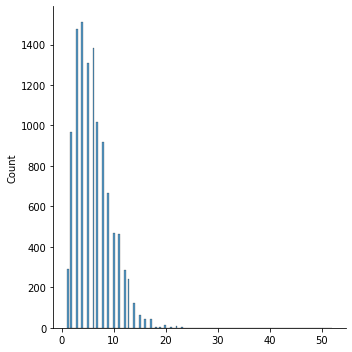

In [ ]:
# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in subjects_idx]

print('평균 =', np.mean(n_len))
print('최소 =', np.min(n_len))
print('최대 =', np.max(n_len))
print('중앙값 =', np.median(n_len))

sns.displot(n_len)
plt.show()

In [ ]:
p_data.shape, w_data.shape, y_data.shape

print(p_data[5], w_data[5])

(36916, 1)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Concatenate, Average, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [ ]:
p_size = len(paragraph_id)
vocab_size = len(word2idx) + 1
emb_size = 64

p_input = Input(shape = (1, ))
w_input = Input(shape = (3, ))

p_emb = Embedding(p_size, emb_size, input_length=1, name="H")(p_input)
w_emb = Embedding(vocab_size, emb_size, input_length=3)(w_input)

emb = Concatenate(axis=1)([p_emb, w_emb])
flat = Flatten()(emb)

y_output = Dense(vocab_size, activation='softmax')(flat)

pvdm = Model([p_input, w_input], y_output)
pvdm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001))
pvdm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
H (Embedding)                   (None, 1, 64)        724096      input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 64)        506816      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
hist = pvdm.fit([p_data, w_data], y_data, epochs=30, batch_size=512)

Epoch 1/30
73/73 [==============================] - 3s 10ms/step - loss: 8.9697
Epoch 2/30
73/73 [==============================] - 1s 10ms/step - loss: 8.9509
Epoch 3/30
73/73 [==============================] - 1s 10ms/step - loss: 8.9263
Epoch 4/30
73/73 [==============================] - 1s 10ms/step - loss: 8.8890
Epoch 5/30
73/73 [==============================] - 1s 10ms/step - loss: 8.8311
Epoch 6/30
73/73 [==============================] - 1s 9ms/step - loss: 8.7457
Epoch 7/30
73/73 [==============================] - 1s 10ms/step - loss: 8.6298
Epoch 8/30
73/73 [==============================] - 1s 10ms/step - loss: 8.4837
Epoch 9/30
73/73 [==============================] - 1s 10ms/step - loss: 8.3108
Epoch 10/30
73/73 [==============================] - 1s 10ms/step - loss: 8.1158
Epoch 11/30
73/73 [==============================] - 1s 10ms/step - loss: 7.9038
Epoch 12/30
73/73 [==============================] - 1s 10ms/step - loss: 7.6811
Epoch 13/30
73/73 [===================

In [ ]:
d_matrix = pvdm.get_layer("H").get_weights()[0]

In [ ]:
print(d_matrix)
print(len(d_matrix))

[[-0.03509744 -0.03640257  0.02484721 ... -0.02757253 -0.01689123
   0.02314471]
 [ 0.01406567 -0.01020765 -0.0074946  ... -0.07102393  0.00251015
   0.03409659]
 [-0.06014661 -0.00322058 -0.08601643 ...  0.00581405  0.00204882
  -0.00265216]
 ...
 [ 0.02737519  0.01641785  0.02223984 ...  0.00770996 -0.01794336
   0.04741699]
 [-0.05974777  0.00488474  0.00678923 ...  0.03597242 -0.02880835
   0.04973502]
 [-0.08477399  0.09224107  0.07299933 ... -0.15651526  0.15933424
   0.11374385]]
11314


In [ ]:
topic = np.array(topic)
topic.shape
len(set(topic))

20

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,f1_score

x_train, x_test, y_train, y_test = train_test_split(d_matrix, topic, test_size=0.2, stratify =topic)
x_train.shape, y_train.shape

((9051, 64), (9051,))

In [ ]:
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_test)
accuracy = accuracy_score(y_test,pred)

print('정확도', accuracy)

정확도 0.22315510384445428


In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)

In [ ]:
print("* 학습용 데이터로 측정한 정확도 = %.2f" % model.score(x_train, y_train))
print("* 시험용 데이터로 측정한 정확도 = %.2f" % model.score(x_test, y_test))

* 학습용 데이터로 측정한 정확도 = 0.19
* 시험용 데이터로 측정한 정확도 = 0.16
